In [1]:
# Standard Library
import os
import time
import random
from pathlib import Path
from itertools import cycle

# Data Manipulation & Visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

# Machine Learning Metrics (Scikit-Learn)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score
)

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data

# Torchvision
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

# Transformers (Hugging Face)
from transformers import (
    ViTModel,
    ViTConfig,
    ViTFeatureExtractor
)
from transformers.modeling_outputs import SequenceClassifierOutput

# Utilities
from tqdm import tqdm
import kagglehub

## Import Data
Make sure to import "small_dataset" folder into your files
- If you do not have the folder, then run the small_dataset_generator.ipynb and integrate it into your file structure

In [2]:
path = kagglehub.dataset_download("shashwatwork/knee-osteoarthritis-dataset-with-severity")

print("Path to dataset files:", path)

train_dir=f'{path}/train'
val_dir=f'{path}/val'
test_dir=f'{path}/test'

100%|██████████| 204M/204M [00:10<00:00, 20.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/versions/1


## Data Preprocessing

In [3]:
# 2. Define Transforms
# ImageNet normalization stats (standard for pre-trained CNNs and ViTs)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transforms for Training (includes Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to fixed size (for CNN and ViT)
    transforms.Grayscale(num_output_channels=3), # Ensure 3 channels (R=G=B) for pre-trained models
    transforms.RandomHorizontalFlip(p=0.5),      # Augmentation: Flip left/right (valid for X-rays)
    transforms.RandomVerticalFlip(p=0.5),        # Augmentation: Flip up/down
    transforms.RandomRotation(degrees=10),       # Augmentation: Slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Transforms for Validation/Test (No Augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 3. Load Data using ImageFolder
# This automatically assigns labels based on folder names (0, 1, 2, 3, 4)
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

# 4. Create DataLoaders
batch_size = 32 # Adjust based on your GPU memory (ViT consumes more memory)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Verification
print(f"Classes found: {train_dataset.classes}") # Should be ['0', '1', '2', '3', '4']
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}") # Should be [32, 3, 224, 224]

Classes found: ['0', '1', '2', '3', '4']
Batch shape: torch.Size([32, 3, 224, 224])


## Show the Preprocessed Images

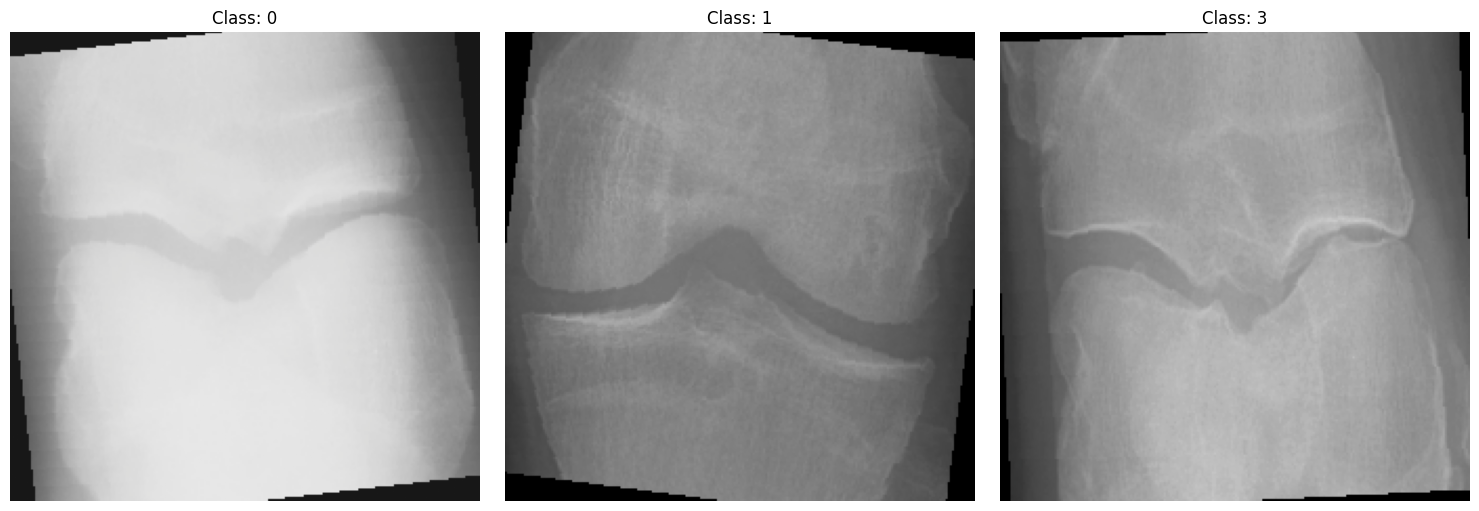

In [4]:
num_images_to_show = 3

plt.figure(figsize=(15, 5))

for i in range(num_images_to_show):
    # Get a random index
    random_idx = random.randint(0, len(train_dataset) - 1)

    # Get the image and label (transforms are applied here)
    image_tensor, label_idx = train_dataset[random_idx]

    # Get the class name from the label index
    label_name = train_dataset.classes[label_idx]

    image_display = image_tensor.permute(1, 2, 0) # C, H, W -> H, W, C

    # Denormalize
    mean_tensor = torch.tensor(mean).view(1, 1, -1)
    std_tensor = torch.tensor(std).view(1, 1, -1)
    image_display = image_display * std_tensor + mean_tensor

    # Clip values to [0, 1] as some might exceed due to denormalization
    image_display = torch.clamp(image_display, 0, 1)

    # Convert to numpy array for matplotlib
    image_display_np = image_display.numpy()

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(image_display_np)
    plt.title(f"Class: {label_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Instantiate Model, Optimizer, and Loss Function

In [15]:
def define_model(model_name, num_classes):
    print(f"\nInitializing {model_name}...")

    model = None
    if model_name == "ResNet18":
        weight = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weight)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif model_name == "ResNet34":
        weight = models.ResNet34_Weights.IMAGENET1K_V1
        model = models.resnet34(weights=weight)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif model_name == "ResNet50":
        weight = models.ResNet50_Weights.IMAGENET1K_V1
        model = models.resnet50(weights=weight)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif model_name == 'ViT_B_16':
        weights = models.ViT_B_16_Weights.IMAGENET1K_V1
        model = models.vit_b_16(weights=weights)
        in_features = model.heads[-1].in_features
        model.heads = nn.Linear(in_features, num_classes)
    elif model_name == 'Swin_V2':
        weights = models.Swin_V2_T_Weights.IMAGENET1K_V1
        model = models.swin_v2_t(weights=weights)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    elif model_name == 'ConvNeXt':
        weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
        model = models.convnext_tiny(weights=weights)
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(in_features, num_classes)

    for param in model.parameters():
        param.requires_grad = True

    return model

In [40]:
num_classes = len(train_dataset.classes)

# Use train_dataset.targets directly as it's a list of class indices
# Convert to numpy array to perform element-wise comparison and sum
train_labels = np.array(train_dataset.targets)

# Calculate class weights to handle potential class imbalance
# Weight for a class is inversely proportional to its frequency
class_counts = [np.sum(train_labels == i) for i in range(num_classes)]
total_samples = len(train_labels)

# Calculate individual class weights
class_weights_list = []
for count in class_counts:
    # Avoid division by zero if a class has no samples (though unlikely in train set)
    weight = total_samples / (num_classes * count) if count > 0 else 0.0
    class_weights_list.append(weight)

weights = torch.FloatTensor(class_weights_list)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = weights.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=weights)

name = 'ResNet50' # Can Change which model you want here
model = define_model(name, num_classes)


Initializing ResNet50...


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

num_epochs = 25
patience = 10  # How many bad epochs to wait before stopping
trigger_times = 0
best_val_accuracy = 0.0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"Training Model: {name}")

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training loop
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # Fix: torchvision models return the tensor directly, no .logits attribute
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        # Fix: Use outputs directly
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # Fix: Use outputs directly
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            # Fix: Use outputs directly
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    # Save the best model based on validation accuracy
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        print("Saved Best Model!")
    else:
        trigger_times += 1
        print(f"EarlyStopping counter: {trigger_times} out of {patience}")

        if trigger_times >= patience:
            print("Early stopping triggered! validation loss is increasing.")
            break

    scheduler.step(epoch_val_loss)

print(f"Training Finished Model: {name}")

Training Model: ResNet50

Epoch 1/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.60it/s]


Train Loss: 1.4253, Train Accuracy: 0.3446


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.45it/s]


Validation Loss: 1.2280, Validation Accuracy: 0.4492
Saved Best Model!

Epoch 2/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.67it/s]


Train Loss: 1.0905, Train Accuracy: 0.5024


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.60it/s]


Validation Loss: 1.0771, Validation Accuracy: 0.5254
Saved Best Model!

Epoch 3/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.68it/s]


Train Loss: 0.9287, Train Accuracy: 0.5607


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s]


Validation Loss: 0.9761, Validation Accuracy: 0.5811
Saved Best Model!

Epoch 4/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.65it/s]


Train Loss: 0.8650, Train Accuracy: 0.5888


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.46it/s]


Validation Loss: 1.0043, Validation Accuracy: 0.5581
EarlyStopping counter: 1 out of 10

Epoch 5/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.65it/s]


Train Loss: 0.8244, Train Accuracy: 0.5947


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s]


Validation Loss: 0.9249, Validation Accuracy: 0.6017
Saved Best Model!

Epoch 6/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.66it/s]


Train Loss: 0.7772, Train Accuracy: 0.6192


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s]


Validation Loss: 1.0119, Validation Accuracy: 0.5617
EarlyStopping counter: 2 out of 10

Epoch 7/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.66it/s]


Train Loss: 0.7406, Train Accuracy: 0.6263


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.50it/s]


Validation Loss: 0.8996, Validation Accuracy: 0.6077
Saved Best Model!

Epoch 8/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.65it/s]


Train Loss: 0.7157, Train Accuracy: 0.6443


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.23it/s]


Validation Loss: 0.8888, Validation Accuracy: 0.6077
EarlyStopping counter: 3 out of 10

Epoch 9/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.65it/s]


Train Loss: 0.7056, Train Accuracy: 0.6404


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.35it/s]


Validation Loss: 0.9471, Validation Accuracy: 0.5508
EarlyStopping counter: 4 out of 10

Epoch 10/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.65it/s]


Train Loss: 0.6832, Train Accuracy: 0.6559


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s]


Validation Loss: 0.9012, Validation Accuracy: 0.5872
EarlyStopping counter: 5 out of 10

Epoch 11/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.66it/s]


Train Loss: 0.6630, Train Accuracy: 0.6613


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s]


Validation Loss: 1.0674, Validation Accuracy: 0.5630
EarlyStopping counter: 6 out of 10

Epoch 12/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.66it/s]


Train Loss: 0.6599, Train Accuracy: 0.6715


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s]


Validation Loss: 0.9213, Validation Accuracy: 0.6077
EarlyStopping counter: 7 out of 10

Epoch 13/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.66it/s]


Train Loss: 0.6202, Train Accuracy: 0.6809


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.51it/s]


Validation Loss: 0.8924, Validation Accuracy: 0.6005
EarlyStopping counter: 8 out of 10

Epoch 14/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.66it/s]


Train Loss: 0.6042, Train Accuracy: 0.6940


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.53it/s]


Validation Loss: 0.8927, Validation Accuracy: 0.6005
EarlyStopping counter: 9 out of 10

Epoch 15/25


Training: 100%|██████████| 181/181 [00:27<00:00,  6.66it/s]


Train Loss: 0.5921, Train Accuracy: 0.6985


Validation: 100%|██████████| 26/26 [00:01<00:00, 18.45it/s]

Validation Loss: 0.9073, Validation Accuracy: 0.6053
EarlyStopping counter: 10 out of 10
Early stopping triggered! validation loss is increasing.
Training Finished Model: ResNet50


## Plot Loss/Accuracy Curves

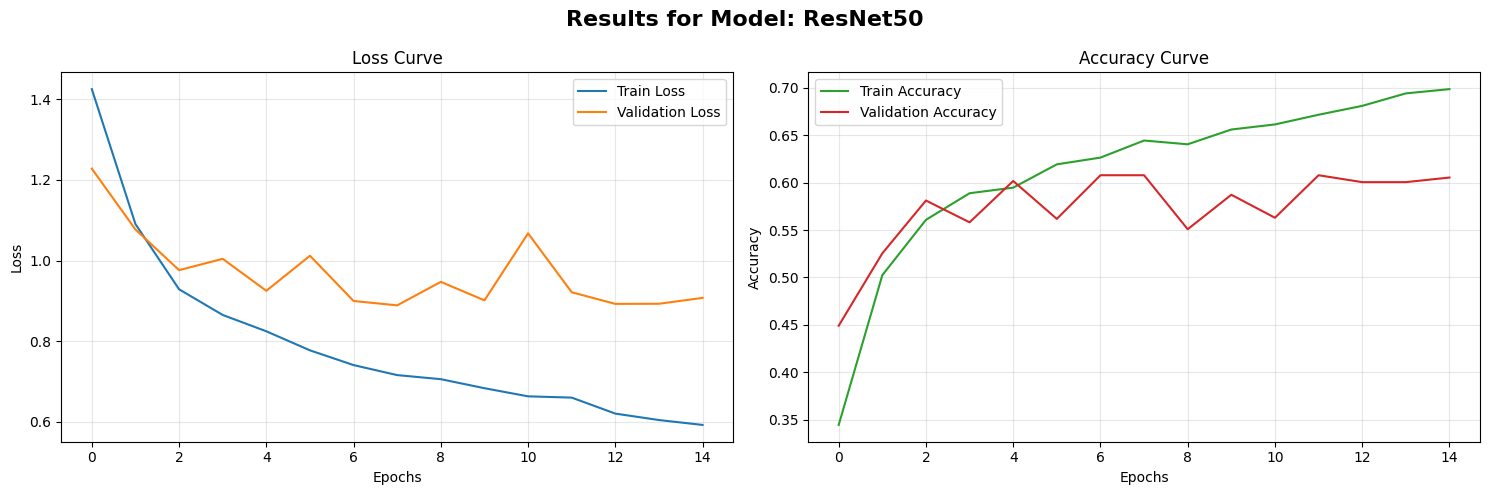

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Add a main title for the entire row (The Model Name)
fig.suptitle(f"Results for Model: {name}", fontsize=16, fontweight='bold')

# Plot Loss
axes[0].plot(train_losses, label='Train Loss', color='tab:blue')
axes[0].plot(val_losses, label='Validation Loss', color='tab:orange')
axes[0].set_title('Loss Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(train_accuracies, label='Train Accuracy', color='tab:green')
axes[1].plot(val_accuracies, label='Validation Accuracy', color='tab:red')
axes[1].set_title('Accuracy Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Adjust layout so titles don't overlap
plt.tight_layout()
plt.show()

## Save and Download Model

In [43]:
torch.save(model.state_dict(), f'best_model_{name}.pth')
print(f"Model {name} saved!")

# Save the loss and accuracy curves
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
torch.save(metrics, f'training_metrics_{name}.pth')
print(f"Training metrics for {name} saved!")

Model ResNet50 saved!
Training metrics for ResNet50 saved!


In [44]:
from google.colab import files

# Download the best model
files.download(f'best_model_{name}.pth')

# Download the training metrics
files.download(f'training_metrics_{name}.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>